### Import required Libraries

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time

### Load MNIST data

In [44]:
from sklearn.datasets import load_digits
mnist = load_digits()
data = mnist['data']
target = (mnist['target']).astype(int)
print(data.shape)
print(target.shape)

(1797, 64)
(1797,)


### Keeping only the entries with label 3 or 8 and relabel target variable to 1(for 3) and -1(for 8)

In [45]:
required = []
for i, val in enumerate(target):
    if val == 3 or val == 8:
        required.append(i)

X = data[required]
Y = target[required]

for i in range(len(Y)):
    if Y[i] == 3:
        Y[i] = 1
    else:
        Y[i] = -1
print(X.shape)
print(Y.shape)

(357, 64)
(357,)


### Split dataset into 60:20:20 ratio for training, validation and testing respectively

In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, random_state=1)

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(213, 64) (213,)
(72, 64) (72,)
(72, 64) (72,)


### Creating SVM class with utility functions like train, predict and also define various kernel functions
### Foemulae used :
#### f(x) =wTx+b
#### If y(i)!=y(j),L= max(0, αj−αi),   H= min(C, C+αj−αi)
#### If y(i)=y(j),L= max(0, αi+αj−C),   H= min(C, αi+αj)
#### αj:=αj+(y(j)(Ei−Ej))/η
#### Ek=f(x(k))−y(k)
#### η=〈x(i), x(i)〉 + 〈x(j), x(j)〉-  2〈x(i), x(j)〉
#### αj:=H if αj> H
####         αj if L≤αj≤H
####          L if αj< L
#### αi:=αi+y(i)y(j)(α(old)j−αj)


In [66]:
class SVM():
    def __init__(self, max_iter=10000, kernel_type='linear', C=1.0, sigma = 1,epsilon=0.001, degree=1):
        self.kernels = {
            'linear' : self.kernel_linear,
            'polynomial' : self.kernel_polynomial,
            'rbf' : self.kernel_rbf
        }
        self.max_iter = max_iter
        self.kernel_type = kernel_type
        self.C = C
        self.sigma = sigma
        self.epsilon = epsilon
        self.degree = degree
    
    def train(self, X, y):
        n, d = X.shape[0], X.shape[1]
        alpha = np.zeros((n))
        kernel = self.kernels[self.kernel_type]
        count = 0
        
        while True:
            count += 1
            alpha_prev = np.copy(alpha)
            
            for j in range(0, n):                
                i = j
                while i == j:
                    i = random.randint(0, n-1)

                x_i, x_j, y_i, y_j = X[i,:], X[j,:], y[i], y[j]
                
                if self.kernel_type == 'rbf':
                    k_ij = kernel(x_i, x_i, self.sigma) + kernel(x_j, x_j, self.sigma) - 2 * kernel(x_i, x_j, self.sigma)
                if self.kernel_type == 'polynomial':
                    k_ij = kernel(x_i, x_i, self.degree) + kernel(x_j, x_j, self.degree) - 2 * kernel(x_i, x_j, self.degree)
                else:
                    k_ij = kernel(x_i, x_i) + kernel(x_j, x_j) - 2 * kernel(x_i, x_j)
                
                if k_ij == 0:
                    continue
                    
                alpha_prime_j, alpha_prime_i = alpha[j], alpha[i]
                if(y_i != y_j):
                    L = max(0, alpha_prime_j - alpha_prime_i)
                    H = min(self.C, self.C - alpha_prime_i + alpha_prime_j)
                else:
                    L = max(0, alpha_prime_i + alpha_prime_j - self.C)
                    H = min(self.C, alpha_prime_i + alpha_prime_j)

                self.w = np.dot(X.T, np.multiply(alpha,y))
                self.b = np.mean(y - np.dot(self.w.T, X.T))

                E_i = np.sign(np.dot(self.w.T, x_i.T) + self.b).astype(int) - y_i
                E_j = np.sign(np.dot(self.w.T, x_j.T) + self.b).astype(int) - y_j

                alpha[j] = alpha_prime_j + float(y_j * (E_i - E_j))/k_ij
                alpha[j] = max(alpha[j], L)
                alpha[j] = min(alpha[j], H)

                alpha[i] = alpha_prime_i + y_i*y_j * (alpha_prime_j - alpha[j])

            diff = np.linalg.norm(alpha - alpha_prev)
            if diff < self.epsilon:
                break

            if count >= self.max_iter:
                print("Iteration number exceeded the max of %d iterations" % (self.max_iter))
                return
        
        self.b = np.mean(y - np.dot(self.w.T, X.T))
        if self.kernel_type == 'linear':
            self.w = np.dot(X.T, np.multiply(alpha,y))

        alpha_idx = np.where(alpha > 0)[0]
        support_vectors = X[alpha_idx, :]
        return support_vectors, count
    
    def predict(self, X):
        return np.sign(np.dot(self.w.T, X.T) + self.b).astype(int)
    
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)
    
    def kernel_polynomial(self, x1, x2, d):
        return (np.dot(x1, x2.T) ** d)
    
    def kernel_rbf(self, x, y, sigma=1):
        if np.ndim(x) == 1 and np.ndim(y) == 1:
            result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
        elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):
            result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
        elif np.ndim(x) > 1 and np.ndim(y) > 1:
            result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
        return result


### Function to calculate different metrics of Confusion matrix

In [65]:
def metrics(labels, predictions):
    TP, TN, FP, FN = 0, 0, 0, 0
    for i in range(len(labels)):
        TP += int(labels[i] == 1 and predictions[i] == 1)
        TN += int(labels[i] == -1 and predictions[i] == -1)
        FP += int(labels[i] == -1 and predictions[i] == 1)
        FN += int(labels[i] == 1 and predictions[i] == -1)
    return TP, FP, TN, FN

### Function to train, cross validate and test the model

In [59]:
def train_and_predict(C=1.0,kernel='linear',sigma=1,test_type='cv',degree=1):
    model = SVM(C=C,kernel_type=kernel,sigma=sigma)
    support_vectors, iterations = model.train(X_train, Y_train)
    sv_count = support_vectors.shape[0]
    
    X = X_val if test_type == 'cv' else X_test
    Y = Y_val if test_type == 'cv' else Y_test
    
    Y_pred = model.predict(X)
    TP, FP, TN, FN = metrics(Y, Y_pred)

    if TP+FP!=0:
        precision = TP / (TP + FP)
    else:
        precidion = np.nan
    if TP+FN!=0:
        recall = TP / (TP + FN)
    else:
        recall = np.nan
    if precision+recall!=0 or precision+recall!=np.nan:
        Fscore = 2 * precision * recall / (precision + recall)
    else:
        Fscore = np.nan
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    print("Support vector count: %d" % (sv_count))
    print("Converged after %d iterations" % (iterations))
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)
    return Y, Y_pred

### Function to plot ROC

In [60]:
def plot_roc(y,y_pred):
    import sklearn.metrics as metrics
    fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    print('AUC: ', roc_auc)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Model Training and Evaluation using Linear Kernel

Support vector count: 24
Converged after 4 iterations
Precision:  0.9722222222222222
Recall:  1.0
F-score:  0.9859154929577464
Accuracy:  0.9861111111111112
-----------------------
CONFUSION MATRIX : 
-----------------------
Predicted  -1   1  All
Actual                
-1         36   1   37
1           0  35   35
All        36  36   72
-----------------------
ROC Curve : 
AUC:  0.9864864864864865


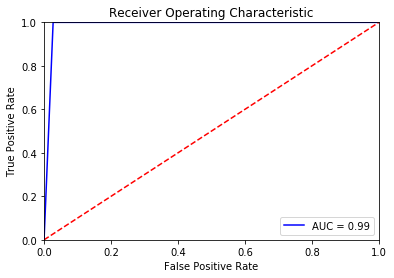

In [62]:
Y, Y_pred = train_and_predict(kernel='linear',C=1.0,test_type='cv')
df_confusion = pd.crosstab(Y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("-----------------------")
print("CONFUSION MATRIX : ")
print("-----------------------")
print(df_confusion)
print("-----------------------")
print("ROC Curve : ")
plot_roc(Y,Y_pred)


### Model Training and Evaluation using Polynomial Kernel with degree 2

Support vector count: 16
Converged after 3 iterations
Precision:  0.9444444444444444
Recall:  0.9714285714285714
F-score:  0.9577464788732395
Accuracy:  0.9583333333333334
-----------------------
CONFUSION MATRIX : 
-----------------------
Predicted  -1   1  All
Actual                
-1         35   2   37
1           1  34   35
All        36  36   72
-----------------------
ROC Curve : 
AUC:  0.9586872586872587


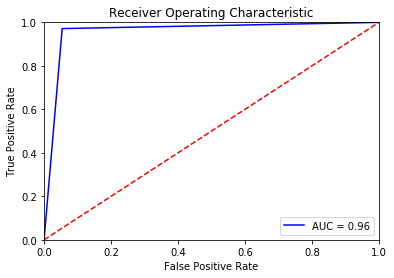

In [64]:
Y, Y_pred = train_and_predict(kernel='polynomial',C=1.0,test_type='cv',degree=2)
df_confusion = pd.crosstab(Y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("-----------------------")
print("CONFUSION MATRIX : ")
print("-----------------------")
print(df_confusion)
print("-----------------------")
print("ROC Curve : ")
plot_roc(Y,Y_pred)

### Model Training and Evaluation using Polynomial Kernel with degree 3

Support vector count: 23
Converged after 3 iterations
Precision:  0.9722222222222222
Recall:  1.0
F-score:  0.9859154929577464
Accuracy:  0.9861111111111112
-----------------------
CONFUSION MATRIX : 
-----------------------
Predicted  -1   1  All
Actual                
-1         36   1   37
1           0  35   35
All        36  36   72
-----------------------
ROC Curve : 
AUC:  0.9864864864864865


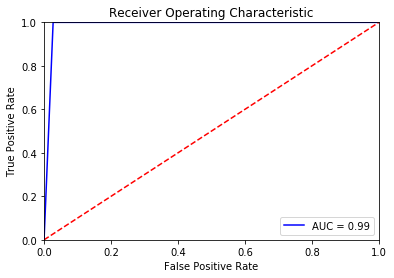

In [16]:
Y, Y_pred = train_and_predict(kernel='polynomial',C=1.0,test_type='cv',degree=3)
df_confusion = pd.crosstab(Y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("-----------------------")
print("CONFUSION MATRIX : ")
print("-----------------------")
print(df_confusion)
print("-----------------------")
print("ROC Curve : ")
plot_roc(Y,Y_pred)

### Model Training and Evaluation using RBF Kernel

Support vector count: 18
Converged after 4 iterations
Precision:  1.0
Recall:  0.9714285714285714
F-score:  0.9855072463768115
Accuracy:  0.9861111111111112
-----------------------
CONFUSION MATRIX : 
-----------------------
Predicted  -1   1  All
Actual                
-1         37   0   37
1           1  34   35
All        38  34   72
-----------------------
ROC Curve : 
AUC:  0.9857142857142858


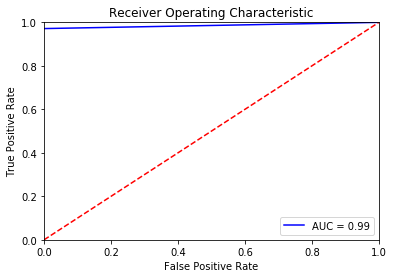

In [17]:
Y, Y_pred = train_and_predict(kernel='rbf',C=1.0,sigma=1,test_type='cv')
df_confusion = pd.crosstab(Y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("-----------------------")
print("CONFUSION MATRIX : ")
print("-----------------------")
print(df_confusion)
print("-----------------------")
print("ROC Curve : ")
plot_roc(Y,Y_pred)

### Using 28 * 28 images with PCA

In [20]:
import pandas as pd
from sklearn.decomposition import PCA

data=pd.read_csv("mnist_data.csv")

not_required=data[(data['label']!=3) & (data['label']!=8)]
data=data.drop(not_required.index, axis=0)

labels=np.array(data['label'])
data=data.drop(['label'], axis=1)

data = data / 255
pca = PCA(n_components=50)
principalComponents = pca.fit_transform(data)
new_data = pd.DataFrame(data = principalComponents)

for i in range(len(labels)):
    if labels[i]==3:
        labels[i]=1
    else:
        labels[i]=-1
n=len(data)
X_train=np.array(new_data[:int(0.6*n)])
Y_train=np.array(labels[:int(0.6*n)])
X_val=np.array(new_data[int(0.6*n):int(0.8*n)])
Y_val=np.array(labels[int(0.6*n):int(0.8*n)])
X_test=np.array(new_data[int(0.8*n):])
Y_test=np.array(labels[int(0.8*n):])

### Using Linear Kernel

Support vector count: 3395
Converged after 55 iterations
Precision:  0.9688622754491018
Recall:  0.9630952380952381
F-score:  0.9659701492537314
Accuracy:  0.966131907308378
-----------------------
CONFUSION MATRIX : 
-----------------------
Predicted   -1    1   All
Actual                   
-1         817   26   843
1           31  809   840
All        848  835  1683
-----------------------
ROC Curve : 
AUC:  0.966126503982376


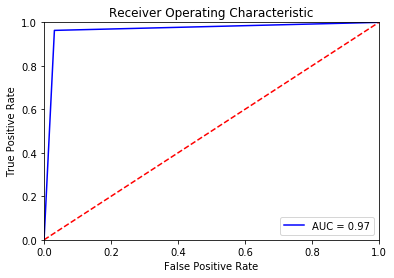

In [21]:
Y, Y_pred = train_and_predict(kernel='linear',C=1.0,test_type='cv')
df_confusion = pd.crosstab(Y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("-----------------------")
print("CONFUSION MATRIX : ")
print("-----------------------")
print(df_confusion)
print("-----------------------")
print("ROC Curve : ")
plot_roc(Y,Y_pred)

### Using Polynomial Kernel

Support vector count: 3422
Converged after 57 iterations
Precision:  0.9676646706586827
Recall:  0.9619047619047619
F-score:  0.9647761194029851
Accuracy:  0.9649435531788473
-----------------------
CONFUSION MATRIX : 
-----------------------
Predicted   -1    1   All
Actual                   
-1         816   27   843
1           32  808   840
All        848  835  1683
-----------------------
ROC Curve : 
AUC:  0.9649381460769362


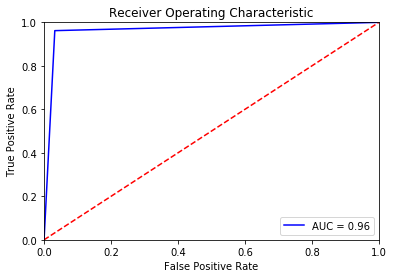

In [23]:
Y, Y_pred = train_and_predict(kernel='polynomial',C=1.0,test_type='cv',degree=2)
df_confusion = pd.crosstab(Y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("-----------------------")
print("CONFUSION MATRIX : ")
print("-----------------------")
print(df_confusion)
print("-----------------------")
print("ROC Curve : ")
plot_roc(Y,Y_pred)

### Using RBF Kernel

Support vector count: 704
Converged after 9 iterations
Precision:  0.951073985680191
Recall:  0.9488095238095238
F-score:  0.9499404052443384
Accuracy:  0.9500891265597148
-----------------------
CONFUSION MATRIX : 
-----------------------
Predicted   -1    1   All
Actual                   
-1         802   41   843
1           43  797   840
All        845  838  1683
-----------------------
ROC Curve : 
AUC:  0.9500868496864938


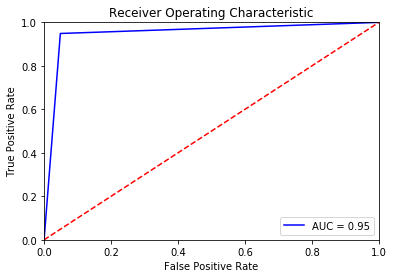

In [22]:
Y, Y_pred = train_and_predict(kernel='rbf',C=1.0,sigma=1,test_type='cv')
df_confusion = pd.crosstab(Y, Y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("-----------------------")
print("CONFUSION MATRIX : ")
print("-----------------------")
print(df_confusion)
print("-----------------------")
print("ROC Curve : ")
plot_roc(Y,Y_pred)